In [1]:
# make sure the notebook reloads the module each time we modify it
%load_ext autoreload
%autoreload 2

# Uncomment the next line if you want to be able to zoom on plots
%matplotlib notebook 

In [2]:
import parametric_regression_student_version as pr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
import numpy as np
import pymc3 as pm

## Preparing data and utilities

I've prepared a function to generate regression data
$$
y \sim \mathcal{N}(X\theta_{\text{true}}, \sigma^2 I). 
$$
Check how $\theta_{\text{true}}$ is generated, with a few ``support variables", and the rest of the coordinates close to zero.

<IPython.core.display.Javascript object>


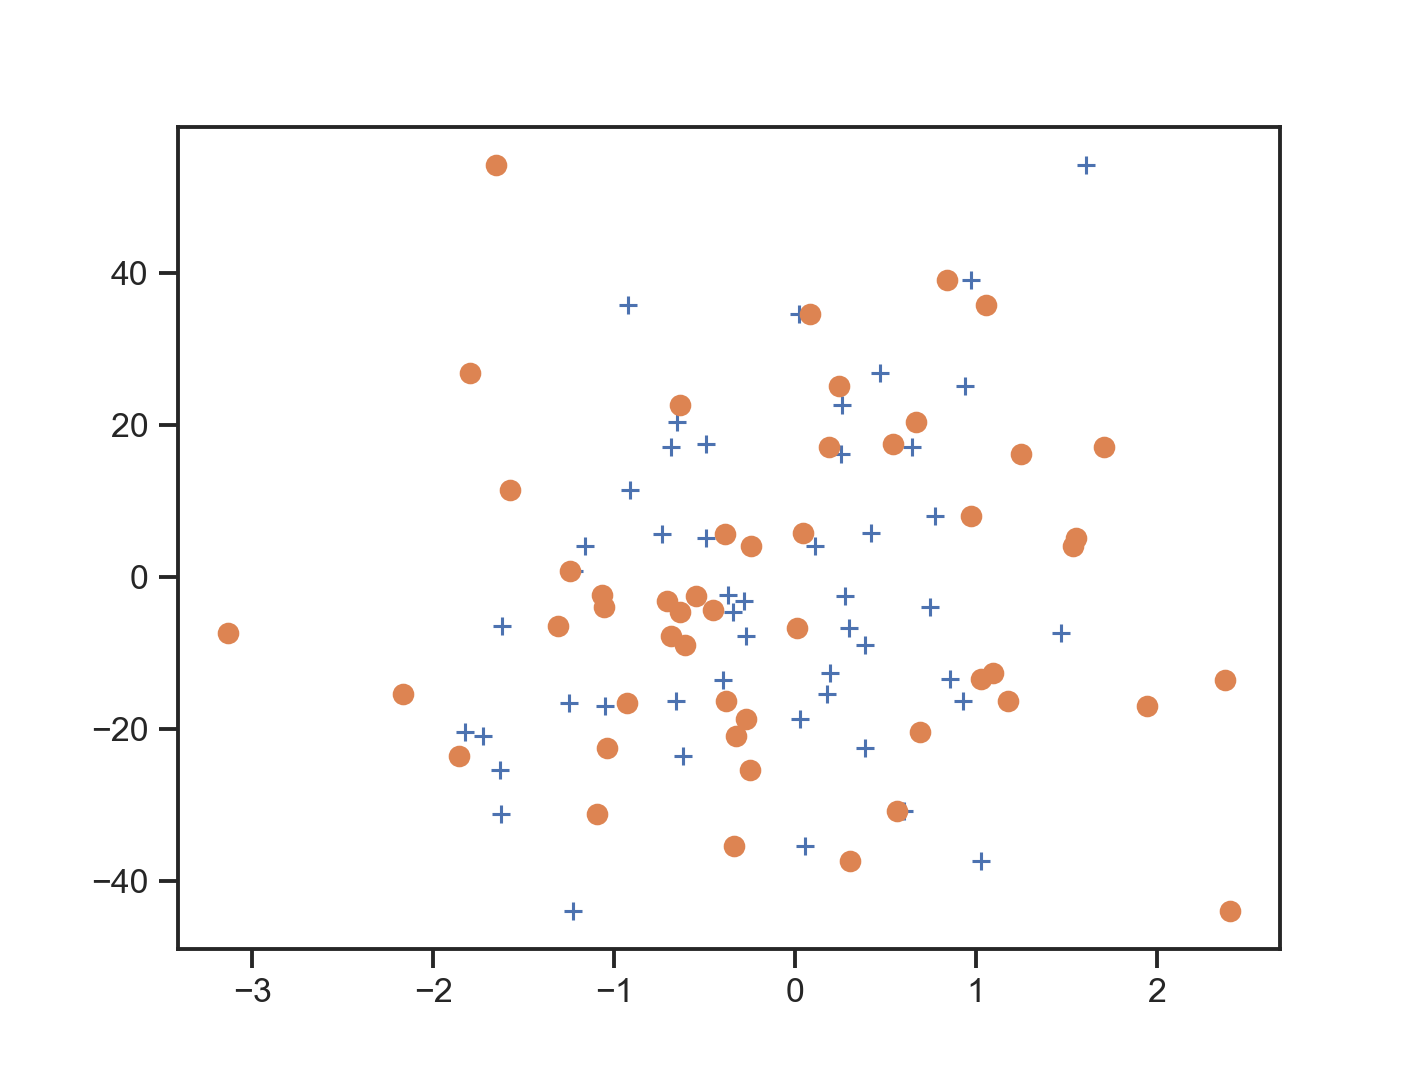

In [3]:
dimension = 100
sample_size = 50
X, y, theta_true, sigma_noise, indices_support = pr.generate_data(sample_size = sample_size, 
                                                        dimension = dimension, seed = 3)
plt.plot(X[:,indices_support[0]], y, '+')
plt.plot(X[:,0], y, 'o')
plt.show()

I've prepared a function to plot an estimator and the corresponding error bars, and compare it to the underlying true $\theta_{\text{true}}$ in green. The bottom plot is the same, but with $\theta_{\text{true}}$ substracted.

<IPython.core.display.Javascript object>


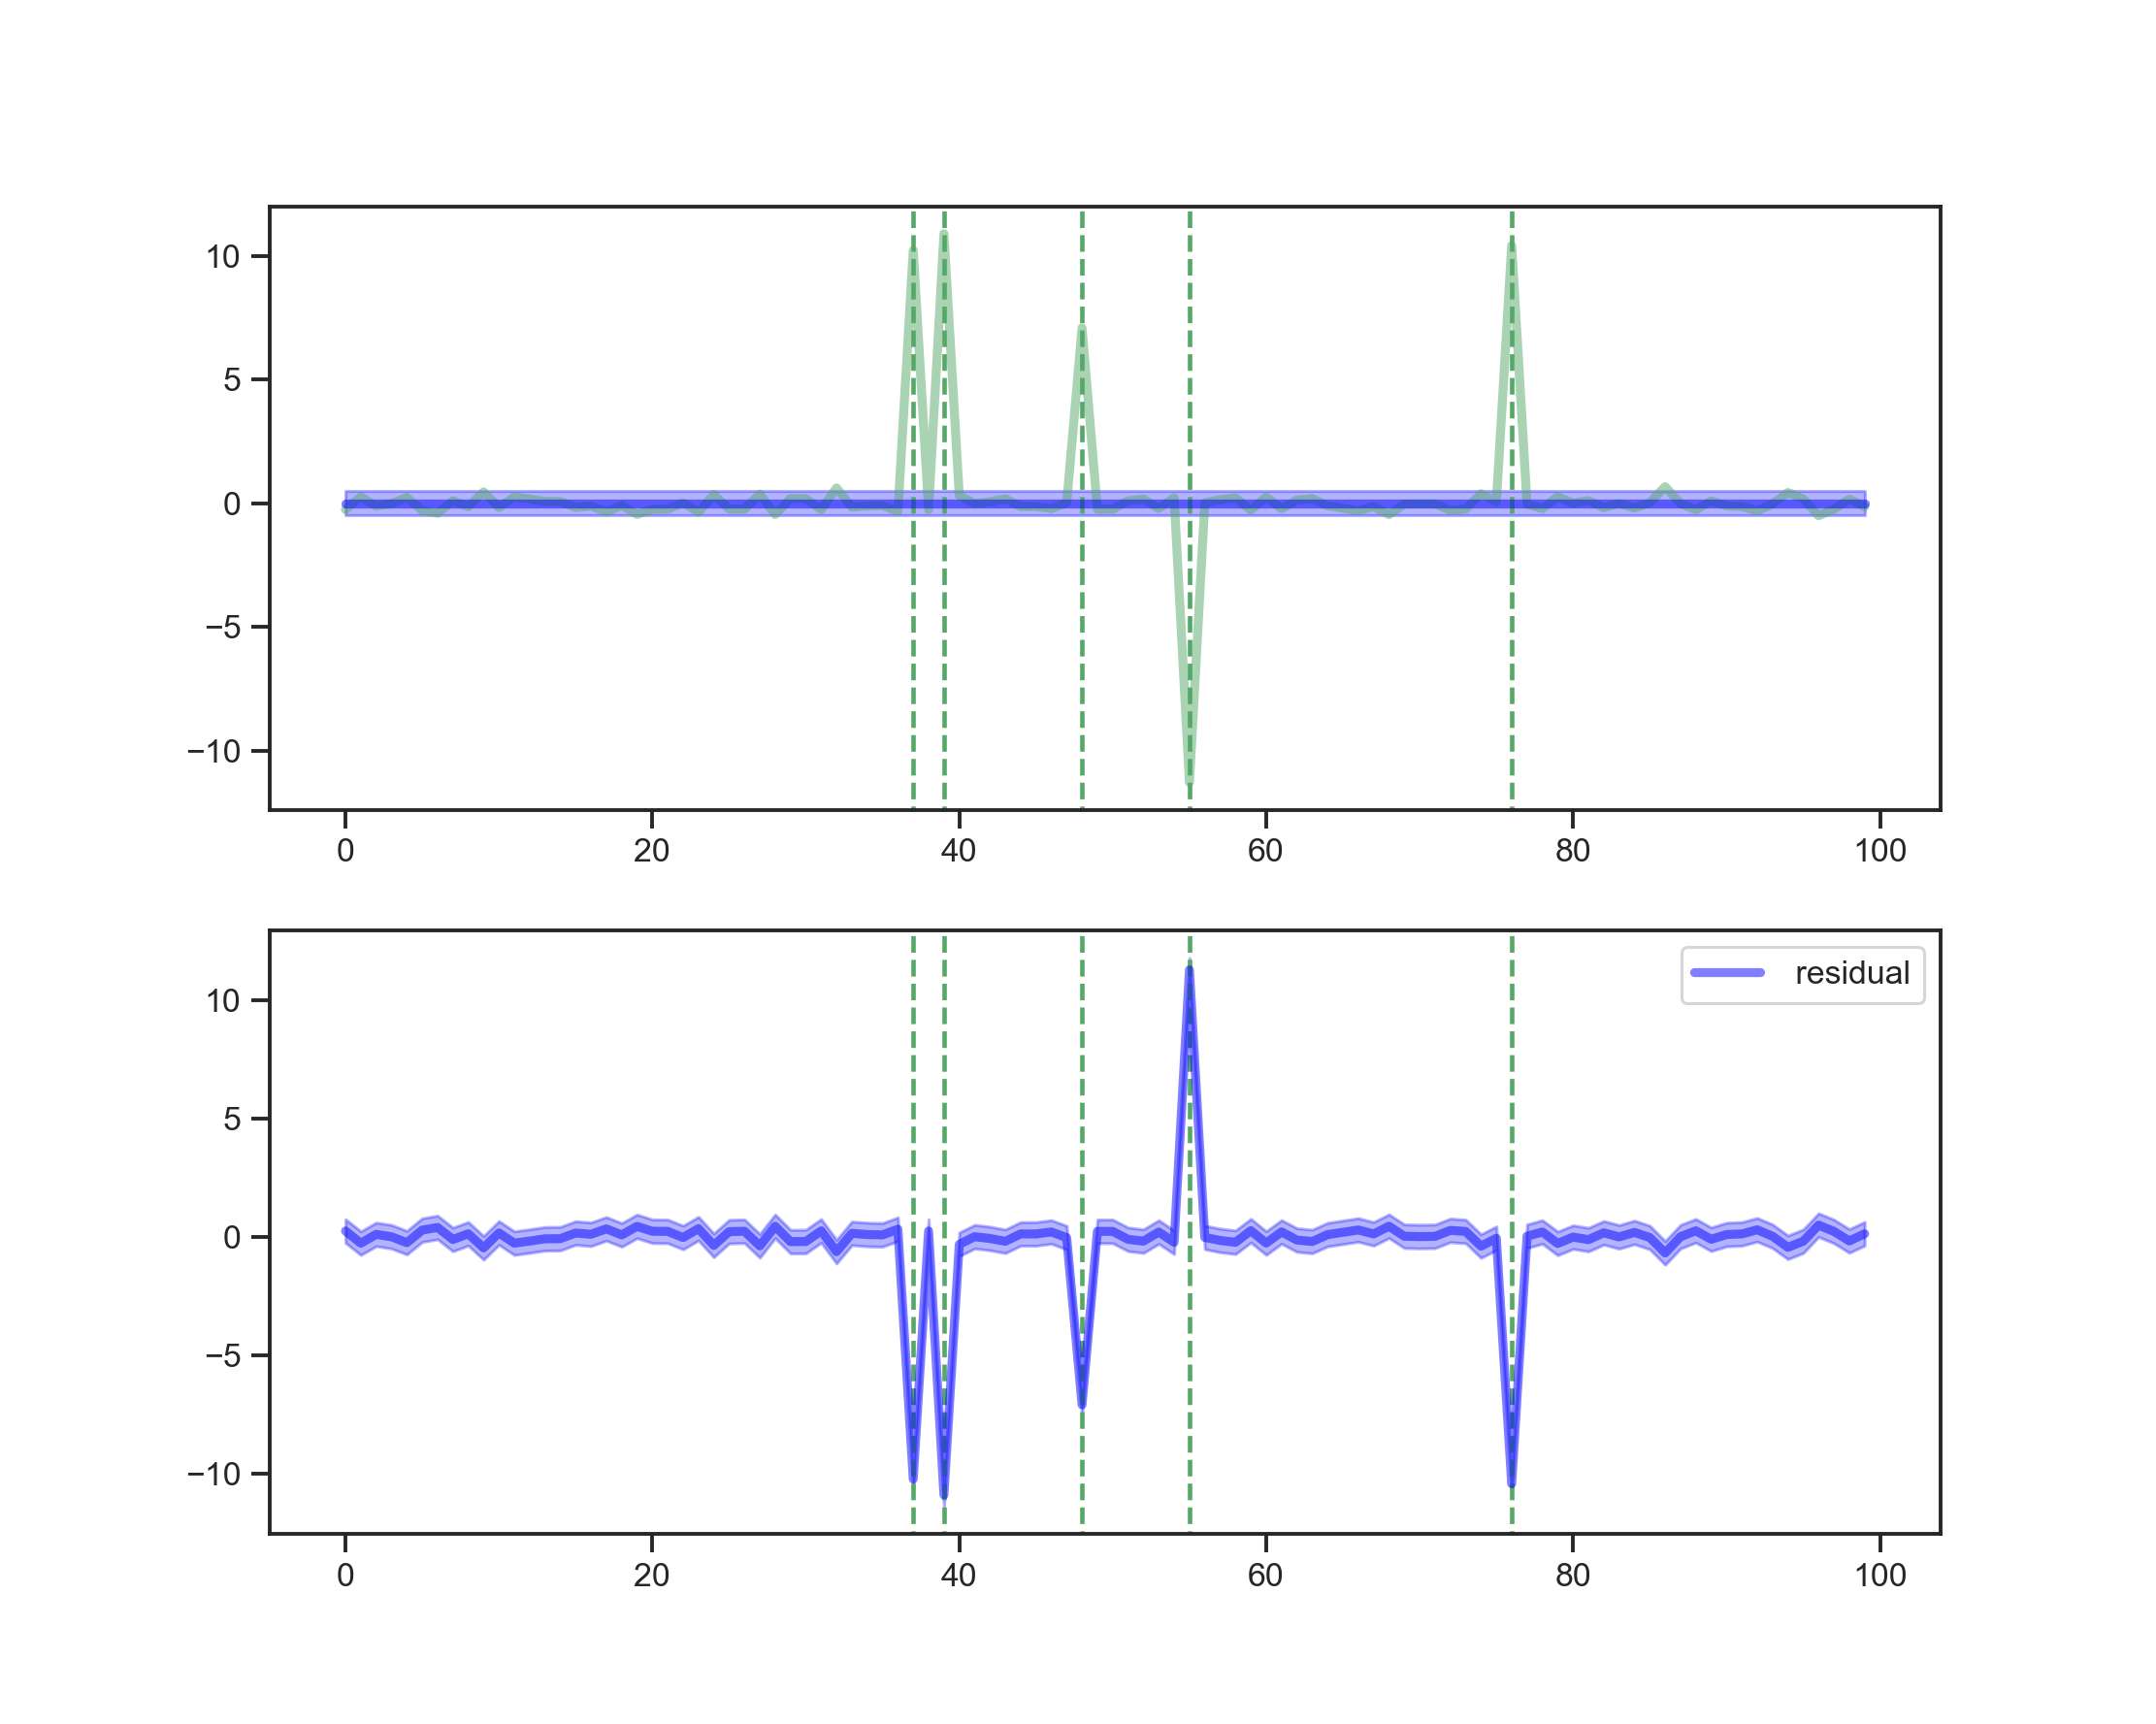

In [4]:
fake_std = .5*np.ones(theta_true.shape)
fake_theta_hat = np.zeros(theta_true.shape)
fig, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, color="blue", theta_true=theta_true, indices_support=indices_support, 
                     theta_hat=fake_theta_hat, lower_bound=fake_theta_hat-fake_std, 
                     upper_bound=fake_theta_hat+fake_std)
plt.show()

## Using sklearn's lasso implementation as baseline

Your first exercise is to get scikit-learn's lasso estimate as a baseline. Go to the companion Python file, and fill in the corresponding function. Then plot your estimate and comment.

In [5]:
theta_lasso = pr.get_sklearn_lasso_estimate(X, y)

<IPython.core.display.Javascript object>


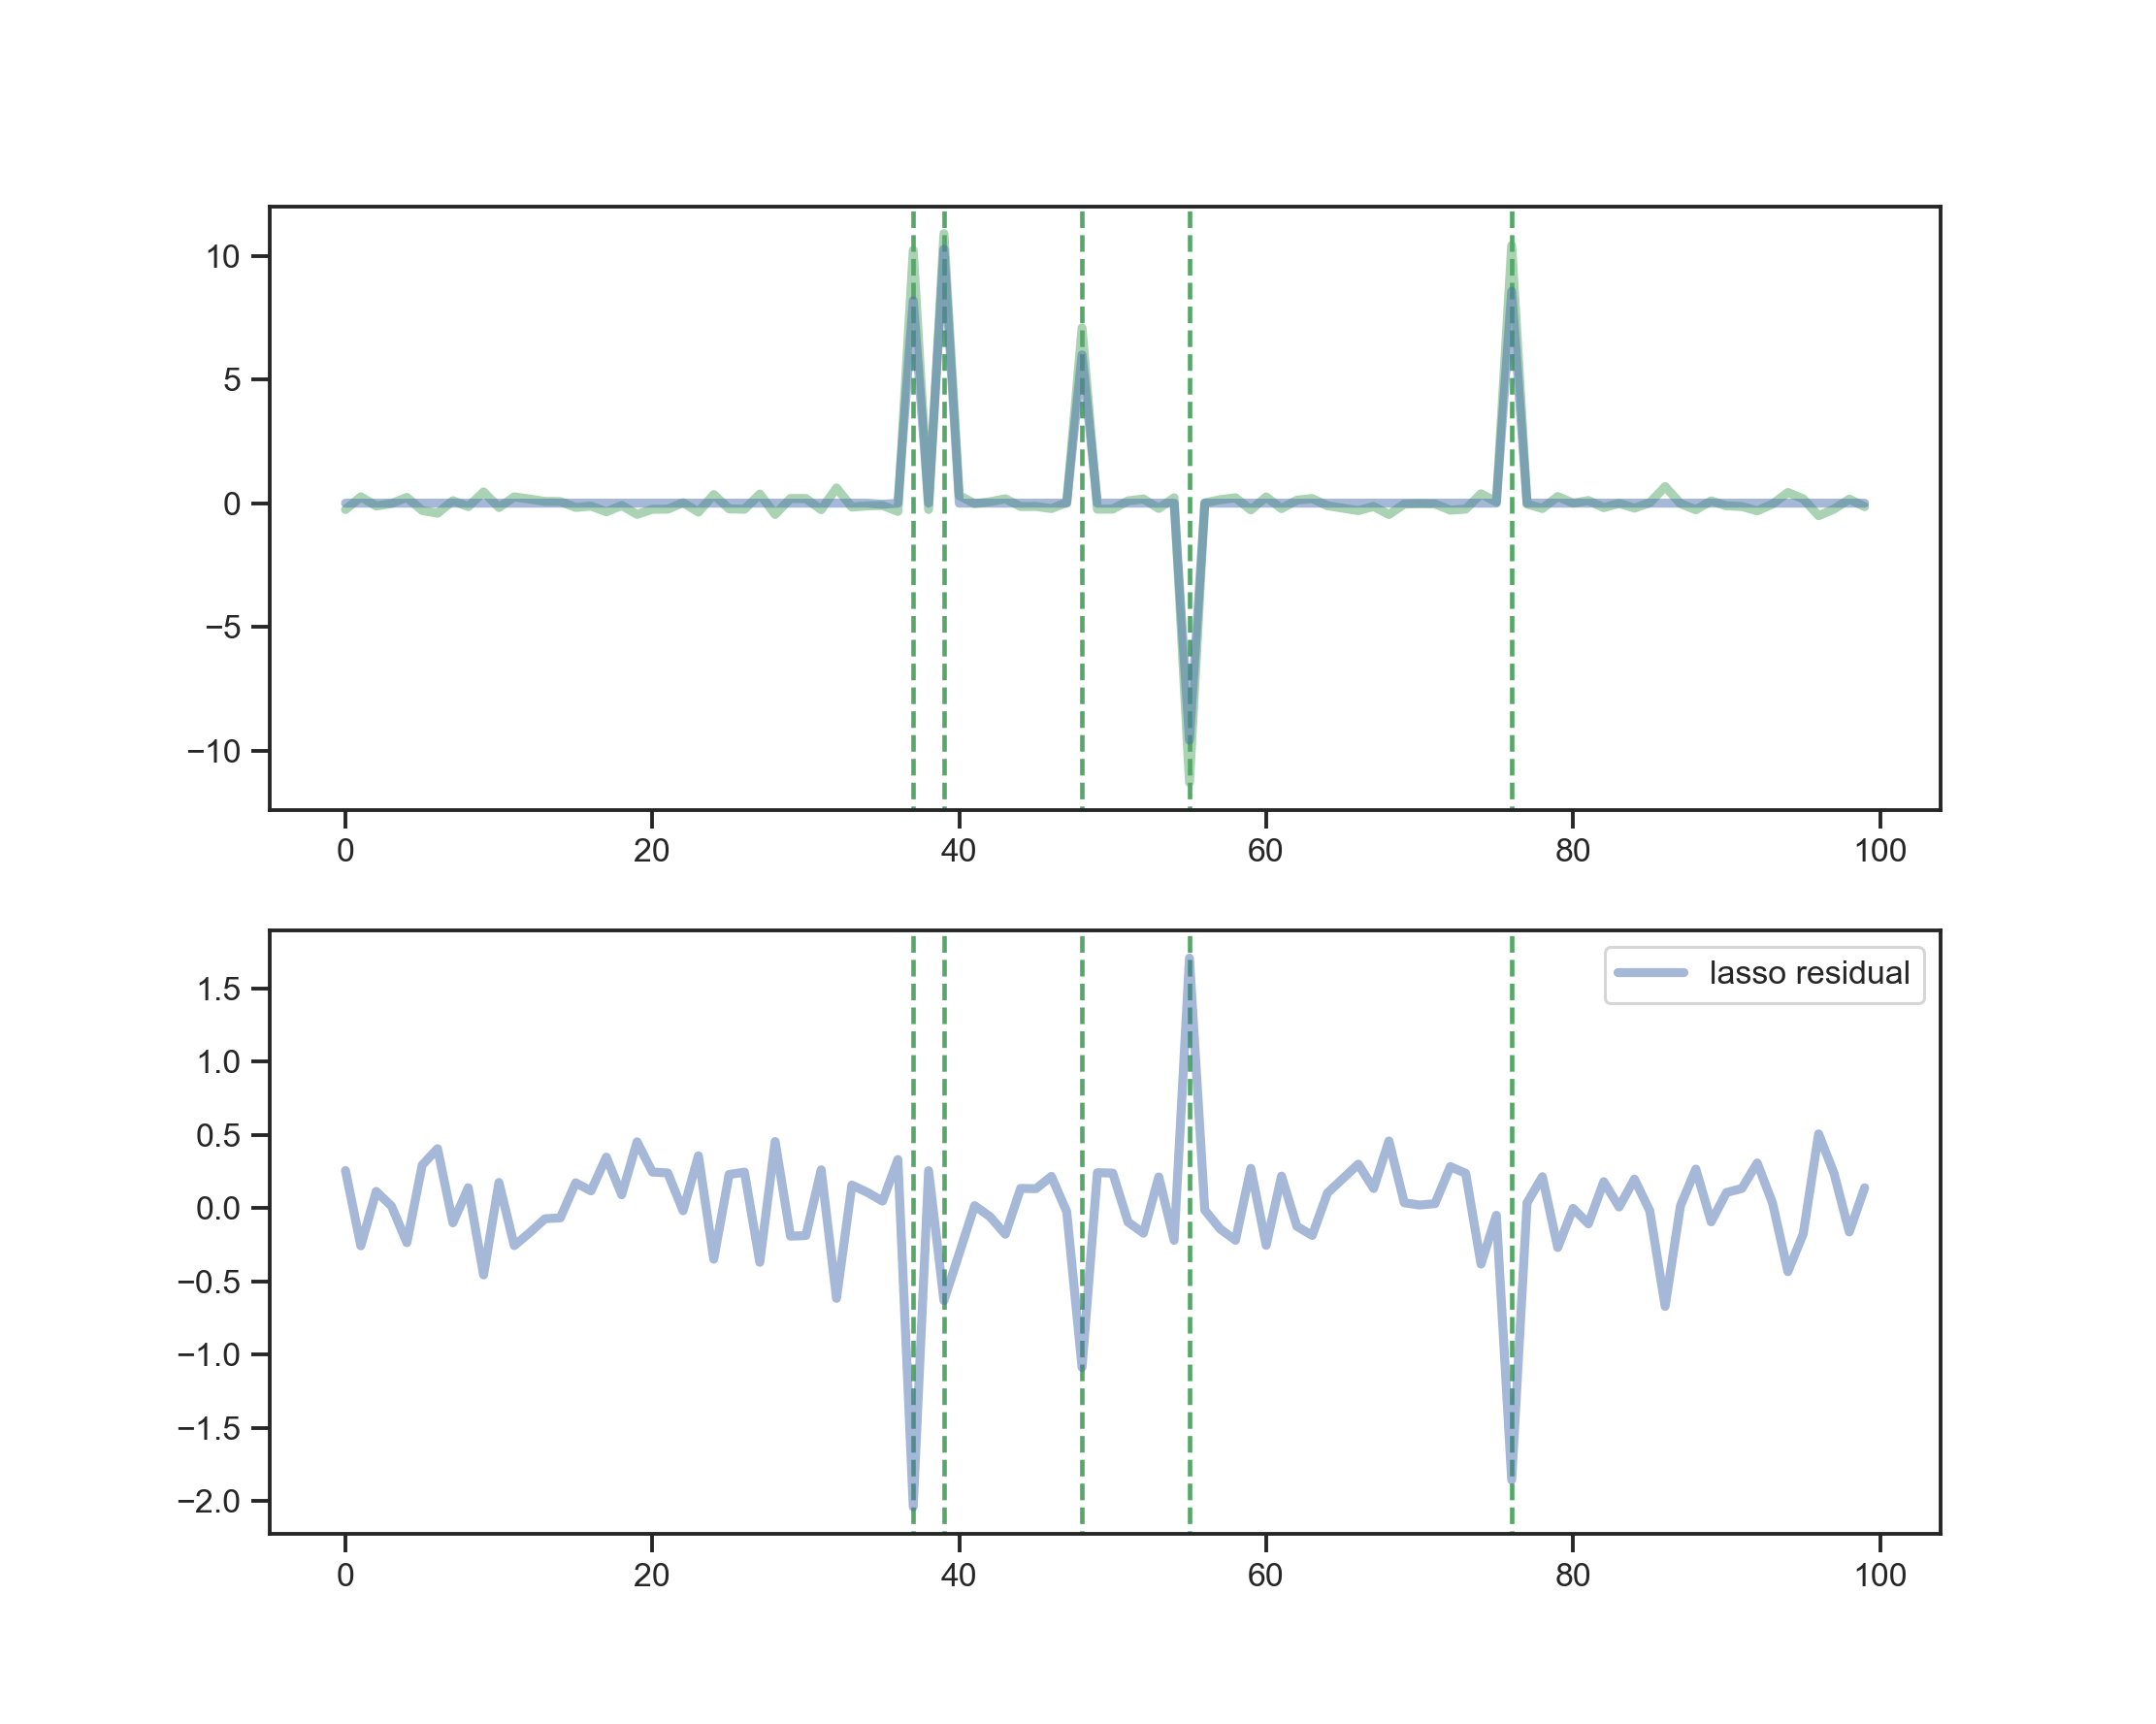

In [6]:
fig, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, theta_true=theta_true, indices_support=indices_support, theta_hat=theta_lasso, label="lasso")
plt.show()

## Bayesian lasso using a Laplace prior

You second exercise is to use `pymc3` to implement Bayesian linear regression with a Laplace prior. Again, fill in the corresponding function in the companion Python file. You should output a `pymc3` Trace object, with the $\theta$ variable of our regression problem named `theta`. Play around with different MCMC kernels.

*Hint*: Remember, the Laplace prior is the one that makes the MAP estimator be the solution to the frequentist Lasso.

In [7]:
trace = pr.get_mcmc_sample_for_laplace_prior(X, y)
accept = np.sum(trace['theta'][1:,0] != trace['theta'][:-1,0])
print("Acceptance Rate: ", accept/trace['theta'][:,0].shape[0])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 22000/22000 [01:05<00:00, 337.25draws/s]


Acceptance Rate:  0.99995


In [18]:
# Let's check a summary of that trace, find out what the columns mean in the doc
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta__0,-0.447241,0.753791,0.008512,-2.027823,0.995515,9235.712624,1.000063
theta__1,0.055051,0.813873,0.008042,-1.606660,1.728035,9869.480552,1.000020
theta__2,0.186631,0.715859,0.007365,-1.219629,1.698798,10064.670576,1.000334
theta__3,-0.235422,0.869141,0.009357,-2.176729,1.383682,9888.556334,1.000064
theta__4,0.398011,0.796229,0.008040,-1.056511,2.117513,8621.984410,1.000048
...,...,...,...,...,...,...,...
theta__95,0.012039,0.816022,0.008382,-1.713041,1.635769,11251.801807,0.999793
theta__96,-0.246339,0.905080,0.008491,-2.141655,1.540810,10652.071224,0.999863
theta__97,-0.190992,0.622390,0.006734,-1.566335,0.973355,8787.397580,0.999816
theta__98,-0.118430,0.887747,0.008076,-2.004710,1.599907,10337.697034,0.999767


In [ ]:
# Plot here a few trajectories of the chain corresponding to a variable in and out of support. 
plt.show()

Your next exercise is to define the Bayesian estimator $\hat\theta_B$ for the squared loss, along with two vectors of length $d$ as well. They should contain the lower limit and the upper limit, respectively, of a 95% credible interval for each component of $\theta$. I've filled the arrays with zeros for now.

In [19]:
theta_laplace = trace.get_values('theta').mean(0) # not expected to show much sparsity
lower_bound_laplace = np.quantile(trace.get_values('theta'), 0.025, axis=0)
upper_bound_laplace = np.quantile(trace.get_values('theta'), 0.975, axis=0)

<IPython.core.display.Javascript object>


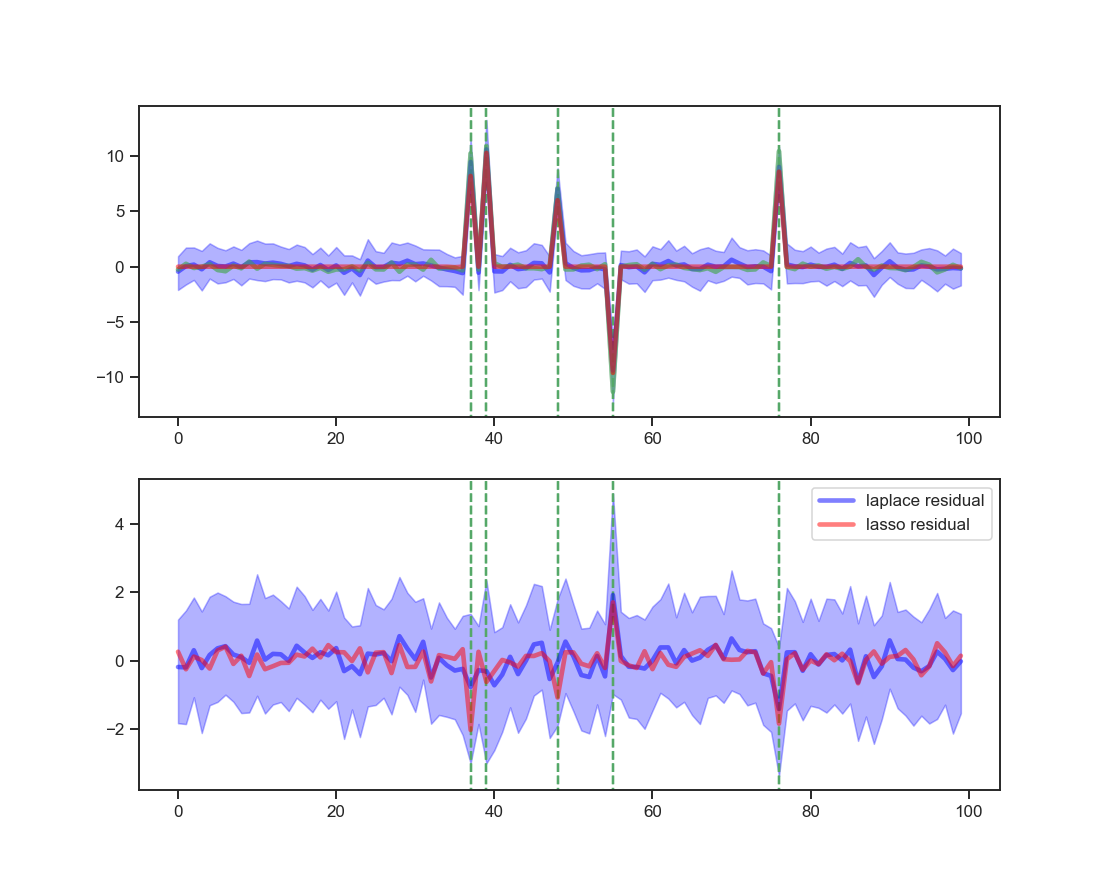

In [20]:
f, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_laplace, lower_bound=lower_bound_laplace, upper_bound=upper_bound_laplace,
             color="blue", label="laplace")
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_lasso, color="red", label="lasso")
plt.show()

The Laplace prior usually tends to overregularize. Can you get rid of that problem playing with the parameters of the prior?

## Bayesian lasso using the horseshoe prior

We'll try to enforce some sparsity using a different prior, the ``horseshoe prior" of [Carvalho et al. '10](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&ved=2ahUKEwj11da8iZvnAhWJz4UKHZSXCccQFjABegQIBBAB&url=ftp%3A%2F%2Fwebster.stat.duke.edu%2Fpub%2FWorkingPapers%2F08-31.pdf&usg=AOvVaw09RPSqHPGq9kyfLBNsMJE2). Your next exercise is to repeat the steps of the Laplace prior for the horseshoe, and see what we gained/lost.

In [ ]:
trace_horseshoe = pr.get_mcmc_sample_for_horseshoe_prior(X, y)

In [ ]:
pm.summary(trace)

In [ ]:
# Again, fill in the Bayesian estimator for the squared loss and credible intervals.
theta_horseshoe = np.zeros((dimension,))
lower_bound_horseshoe = np.zeros((dimension,))
upper_bound_horseshoe = np.zeros((dimension,))

In [ ]:
# This will plot your estimates so far for comparison
f, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_laplace, lower_bound=lower_bound_laplace, upper_bound=upper_bound_laplace,
                     color="blue", label="laplace")
pr.plot_coefficients(ax, theta_true=theta_true, indices_support=indices_support, theta_hat=theta_horseshoe, lower_bound=lower_bound_horseshoe, 
                     upper_bound=upper_bound_horseshoe, color="orange", label="horseshoe")
#pr.plot_coefficients(theta_true, theta_lasso, color="red", label="lasso")

plt.show()

## Bayesian lasso using the Finnish horseshoe prior

If you've made it so far, you've deserved to pick your last exercise: either 
* find a dataset of your liking to which you apply the previous estimators. 
* delve into more subtle priors, with, e.g. the Finnish horseshoe prior of [Piironen and Vehtari '17](https://arxiv.org/pdf/1707.01694.pdf). You can use the cells below.
* Try to learn more about HMC and its NUTS variant, the flagship MCMC kernel of `pymc3`. How are the HMC parameters tuned in NUTS? Can you prove that the resulting Markov kernel leaves the target distribution invariant?

In [ ]:
trace_finnish_horseshoe = pr.get_mcmc_sample_for_finnish_horseshoe_prior(X, y)

In [ ]:
theta_finnish_horseshoe = np.zeros((dimension,))
lower_bound_finnish_horseshoe = np.zeros((dimension,))
upper_bound_finnish_horseshoe = np.zeros((dimension,))

In [ ]:
f, ax = plt.subplots(2, figsize=(10,8))
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_laplace,
                     color="blue", label="laplace")
pr.plot_coefficients(ax, theta_true=theta_true, indices_support=indices_support, theta_hat=theta_horseshoe, lower_bound=lower_bound_horseshoe, 
                     upper_bound=upper_bound_horseshoe, color="orange", label="horseshoe")
pr.plot_coefficients(ax, theta_true, indices_support=indices_support, theta_hat=theta_finnish_horseshoe, lower_bound=lower_bound_finnish_horseshoe, 
                     upper_bound=upper_bound_finnish_horseshoe, color="magenta", label="finnish")
#pr.plot_coefficients(theta_true, theta_lasso, color="red", label="lasso")

plt.show()